In [101]:
import logging
from time import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_regression
logging.basicConfig(level=logging.INFO)
df = pd.read_csv("data/train.csv")
# df = df.sample(10000, random_state=42)

In [102]:


##### PREPROCESSING ######
print("Training Regression Model")
logging.info("1. Setting index and renaming Annual Premium col")

# Set index
df.set_index("id", inplace=True)

# Set Response
df.rename(columns={"Annual_Premium": "dependent"}, inplace=True)

logging.info("2. deduplication")
# Check if duplicate IDs exist
if not df.index.is_unique:
    # Deduplicate id
    df.loc[~df.index.duplicated(), :]

logging.info("3. Remove missing Responses")
# Remove any missing Responses
df.dropna(subset=["dependent"], inplace=True)



INFO:root:1. Setting index and renaming Annual Premium col
Training Regression Model
INFO:root:2. deduplication
INFO:root:3. Remove missing Responses


In [103]:
# We need to adjust a few of the variables which are currently numeric and need to be categorical
cols_to_cat = ["Driving_License", "Previously_Insured", "Policy_Sales_Channel", "Region_Code", "Response"]
logging.info(f"4. Converting {cols_to_cat} to categorical columns")
df[cols_to_cat] = df[cols_to_cat].astype("category")

cat_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()
num_cols = df.select_dtypes(exclude=["category", "object"]).columns.tolist()

logging.info(f"5. Getting categorical and numerical cols \
    {len(cat_cols) + len(num_cols)} should equal {df.shape[1]}")
logging.info(f"6. Imputing numerical cols")
# Impute numerical with mean
for col in num_cols:
    df[col].fillna(df[col].mean(), inplace=True)

logging.info(f"7. Imputing categorical cols")
# Impute categorical with most frequent
for col in cat_cols:
    df[col].fillna(df[col].mode(), inplace=True)

INFO:root:4. Converting ['Driving_License', 'Previously_Insured', 'Policy_Sales_Channel', 'Region_Code', 'Response'] to categorical columns
INFO:root:5. Getting categorical and numerical cols     11 should equal 11
INFO:root:6. Imputing numerical cols
INFO:root:7. Imputing categorical cols


In [104]:

logging.info(f"8. Normalizing numerical cols")
# Normalize numerical cols
num_cols.remove("dependent")
df[num_cols] = df[num_cols].apply(lambda x: x/x.max(), axis=0)

logging.info(f"9. OneHot Encoding categorical cols")
# Onehot encode categorical cols (excluding Response)
df = pd.get_dummies(df, columns=cat_cols)

INFO:root:8. Normalizing numerical cols
INFO:root:9. OneHot Encoding categorical cols


In [105]:
df.head()

,Age,dependent,Vintage,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Region_Code_0.0,Region_Code_1.0,Region_Code_2.0,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Response_0,Response_1
id,,,,,,,,,,,,,,,,,,,,,
1,0.517647,40454.0,0.725753,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.894118,33536.0,0.612040,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.552941,38294.0,0.090301,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.247059,28619.0,0.678930,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0.341176,27496.0,0.130435,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [106]:
print("\n\n~~~~~~~~~Setting up and training model~~~~~~~~~\n")
logging.debug(df.columns)
logging.debug(df.head())
without_outliers = df[(df.dependent<=60000) & (df.dependent>=10000)]
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("dependent", axis=1),
    df.dependent,
    test_size=0.2,
    random_state=42
)



~~~~~~~~~Setting up and training model~~~~~~~~~



In [ ]:
df[df.dependent <= 3000].dependent.hist()

In [109]:
y_trans = df.dependent.apply(np.log1p)

<AxesSubplot:>

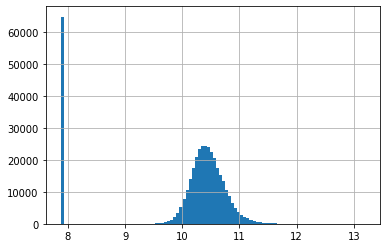

In [111]:
y_trans.hist(bins=100)

In [117]:
y_trans.values.std(ddof=1)*2

2.009903002528537

In [73]:
##### MODEL LM #####
reg = LinearRegression()
logging.info("Training model")
t1 = time()
reg.fit(X_train, y_train)
t2 = time()
logging.info(f"Training took {t2-t1:.2f} seconds")

t1 = time()
y_test_pred = reg.predict(X_test)
t2 = time()
print(f"Predictions took {t2-t1:.2f} seconds")

print("Explaining the Regressor\n")
print(f"Regression intercept: {reg.intercept_}")
# print(f"Coefficients")
# print(reg.coef_)


INFO:root:Training model
INFO:root:Training took 26.17 seconds
Predictions took 0.77 seconds
Explaining the Regressor

Regression intercept: 2130044655412887.8


In [74]:

print("\n\n~~~~~~~~Evaluation~~~~~~~~~~~\n")
print(f"Annual Premium mean: {df.dependent.mean()} std_Dev: {df.dependent.std()}")
print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, y_test_pred),1)}")
print(f"Mean Squared Error: {round(mean_squared_error(y_test, y_test_pred),1)}")
print(f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y_test, y_test_pred)),1)}")



~~~~~~~~Evaluation~~~~~~~~~~~

Annual Premium mean: 30564.389581458323 std_Dev: 17213.155056980126
Mean Absolute Error: 909683338.4
Mean Squared Error: 1.5768543339815864e+22
Root Mean Squared Error: 125572860681.8


In [75]:
####### MODEL RF REGRESSION ##########
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
logging.info("Training model")
t1 = time()
rf_reg.fit(X_train, y_train)
t2 = time()
logging.info(f"Training took {t2-t1:.2f} seconds")

t1 = time()
y_test_pred_rf = rf_reg.predict(X_test)
t2 = time()
print(f"Predictions took {t2-t1:.2f} seconds")

# print(f"Coefficients")
# print(reg.coef_)


INFO:root:Training model
INFO:root:Training took 13693.38 seconds
Predictions took 55.25 seconds


In [76]:

print("\n\n~~~~~~~~Evaluation~~~~~~~~~~~\n")
print(f"Annual Premium mean: {df.dependent.mean()} std_Dev: {df.dependent.std()}")
print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, y_test_pred_rf),1)}")
print(f"Mean Squared Error: {round(mean_squared_error(y_test, y_test_pred_rf),1)}")
print(f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),1)}")



~~~~~~~~Evaluation~~~~~~~~~~~

Annual Premium mean: 30564.389581458323 std_Dev: 17213.155056980126
Mean Absolute Error: 11045.7
Mean Squared Error: 256529742.8
Root Mean Squared Error: 16016.5


In [77]:
from sklearn.linear_model import Lasso
####### MODEL RF REGRESSION ##########
lasso_reg = Lasso(alpha=0.1)
logging.info("Training model")
t1 = time()
lasso_reg.fit(X_train, y_train)
t2 = time()
logging.info(f"Training took {t2-t1:.2f} seconds")

t1 = time()
y_test_pred_lasso = lasso_reg.predict(X_test)
t2 = time()
print(f"Predictions took {t2-t1:.2f} seconds")

# print(f"Coefficients")
# print(reg.coef_)


INFO:root:Training model
/home/higgssr/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139748207289.3047, tolerance: 9076728547.152021
  model = cd_fast.enet_coordinate_descent(
INFO:root:Training took 1077.45 seconds
Predictions took 0.91 seconds


In [54]:

print("\n\n~~~~~~~~Evaluation~~~~~~~~~~~\n")
print(f"Annual Premium mean: {df.dependent.mean()} std_Dev: {df.dependent.std()}")
print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, y_test_pred_lasso),1)}")
print(f"Mean Squared Error: {round(mean_squared_error(y_test, y_test_pred_lasso),1)}")
print(f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)),1)}")



~~~~~~~~Evaluation~~~~~~~~~~~

Annual Premium mean: 30541.4799 std_Dev: 18160.936286972596
Mean Absolute Error: 6330.0
Mean Squared Error: 64711127.8
Root Mean Squared Error: 8044.3


<AxesSubplot:>

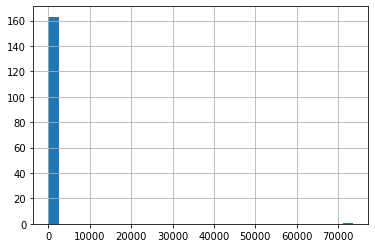

In [45]:
df.quantile(0.99).hist(bins=30)

<AxesSubplot:>

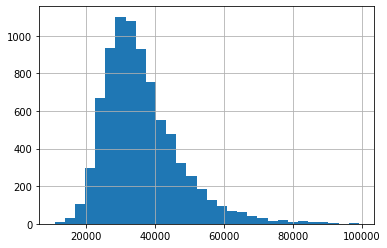

In [47]:
df[(df.dependent<=60000) & (df.dependent>=10000)].dependent.hist(bins=30)

In [35]:
df[df.dependent<3000].dependent
# df.dependent

id
172202    2630.0
160714    2630.0
372604    2630.0
373619    2630.0
179483    2630.0
           ...  
213233    2630.0
242915    2630.0
238281    2630.0
140342    2630.0
98085     2630.0
Name: dependent, Length: 1757, dtype: float64

In [16]:
import amatplotlib.pyplot as plt

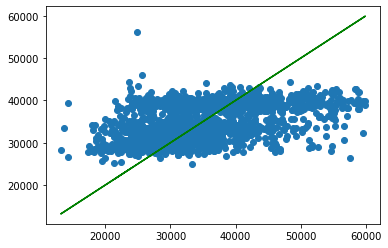

In [63]:
plt.scatter(y_test, y_test_pred_lasso)
plt.plot(y_test, y_test, color="green")
plt.show()

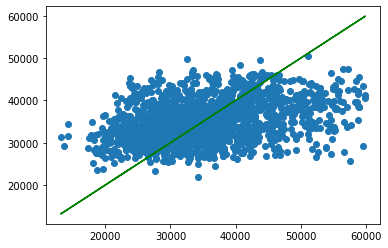

In [65]:
plt.scatter(y_test, y_test_pred_rf)
plt.plot(y_test, y_test, color="green")
plt.show()

In [100]:
df.dependent

AttributeError: 'tuple' object has no attribute 'dependent'

In [66]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
df.get